In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import re
import plotly.express as px
import glob


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [25]:
def clean_tweets_no_lemmatize(tweets):
    '''Cleaning and lemmatizing tweets for further analysis'''
    
    tweets = tweets.drop_duplicates()
    
    #removes links
    tweets = tweets.apply(lambda x: re.sub(r'http\S+', '', x))
    
    #removes twitter usernames
    tweets = tweets.apply(lambda x: re.sub(r'(\s)@\w+', '', x))
    
    #removes non-alpha numeric symbols
    tweets = tweets.apply(lambda x: re.sub(r"[!@#$%^&*()-=_+|;':,.<>?']", '', x))
    
    #removes stop words
    custom_stop_words = ['RT', 'amp', 'u', 'w', 'im']
    stop_words = custom_stop_words + stopwords.words('english')
    tweets = tweets.apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop_words]))
    
    #replace line indents with spaces
    tweets = tweets.apply(lambda x: re.sub(r'\n',' ', x))
    
    #turn data into a list of tweets
    tweet_list = [''.join(i) for i in tweets]
     
    #MAY NOT BE NECESSARY, HAVE TO CHECK
    #combine the words back into tweets
    #out_list = []
    #for tweet in tweet_list:
    #    out_list.append(''.join(tweet))
    
    return(tweet_list)


def create_dictionaries_of_tweets_national():
    '''Creates a dictionary of tweets for each politician'''
    
    out_dict = {}
    
    for filename in glob.glob('data/scraped_twitter_profiles/national/*.pkl'):
        politician_handle = filename.split('/')[-1].split('_')[0]
        with open(filename, 'rb') as file:    
            tweet_df = pickle.load(file)
            out_dict[politician_handle] = clean_tweets_no_lemmatize(tweet_df['tweet'])
    return(out_dict)

def create_dictionaries_of_tweets_mayor():
    '''Creates a dictionary of tweets for each politician'''
    
    out_dict = {}
    
    for filename in glob.glob('data/scraped_twitter_profiles/mayoral/*.pkl'):
        politician_handle = filename.split('/')[-1].split('_')[0]
        with open(filename, 'rb') as file:    
            tweet_df = pickle.load(file)
            out_dict[politician_handle] = clean_tweets_no_lemmatize(tweet_df['tweet'])
    return(out_dict)

national_politicians = create_dictionaries_of_tweets_national()
local_politicians = create_dictionaries_of_tweets_mayor()

national_politicians.update(local_politicians)

In [81]:
def create_sentiment_vectors(list_of_tweets,handle,word=None):
    """
    Purpose: Get total positive, neutral, negative and compound sentiment scores for each tweet and then return the sum
    of all those scores in a single vector for each politician
    
    Arguments: List of tweets
    
    Returns: One row dataframe with total sentiment scores for that politician
    """
    
    #Initializing variables
    neg = 0
    neu = 0
    pos = 0 
    compound = 0
    
    #initializing sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    #performing sentiment analysis on a tweet by tweet basis
    for val in list_of_tweets:
        sentiment_dict = analyzer.polarity_scores(val)
        
        neg += sentiment_dict['neg']
        neu += sentiment_dict['neu']
        pos += sentiment_dict['pos']
        compound += sentiment_dict['compound']
    
    #conditional logic that will change behavior based on if this sentiment vector is only for one word or the whole df
    if word:
        final = pd.DataFrame([[neg,neu,pos,compound]], index=[handle],
                             columns= [word + '_' + val for val in sentiment_dict.keys()])
    else:
        final = pd.DataFrame([[compound]], index=[handle], columns= sentiment_dict.keys())
        
    return final

In [82]:
def get_politician_vectors(tweet_list, twitter_handle ,top_words=True,top_words_amount=200):
    """
    Take politician tweets from last year and turn it vector of words 
    
    Arguments: Twitter handle in string
    
    Returns: Dataframe with vector and number of tweets
    """

    #adding custom stop words for this use case
    addl_stop_words = ['live', 'today', 'must', 'join', 'campaign', 'reporter', 'tune', 'pm', 'et', 'press','weekly',
                  'year','thank', 'thanks', 'support', 'appreciate', 'rsvp', 'say', 'get', 'amp']

    custom_stop_words = stopwords.words('english') + addl_stop_words
    
    
    result = tweet_list
    number_of_tweets = len(result)
    
    #create the document-term matrix
    tfidf = TfidfVectorizer(stop_words=custom_stop_words,ngram_range=(1,3), min_df = 5, max_df=.9, binary=True)
    doc_word = tfidf.fit_transform(result)
    doc_word_df = pd.DataFrame(doc_word.toarray(),columns=tfidf.get_feature_names())
    
    #sum up all columns to get a politican-term vector
    data = np.zeros((1,len(doc_word_df.columns)))
    for i,column in enumerate(doc_word_df.columns):
        data[0,i] = doc_word_df[column].sum()
    
    #put the sums into a new dataframe
    final = pd.DataFrame(data,index=[twitter_handle], columns=doc_word_df.columns)
        
    #get sentiment for top words and add them to the dataframe
    if top_words == True:
        top_words = list(final.T.sort_values(by=twitter_handle,ascending=False).index[0:top_words_amount])
        for word in top_words:
            mini_df = pd.DataFrame(result,columns=['text'])
            tweets_for_this_word = mini_df[mini_df.text.str.contains(word)].text.to_list()
            if len(tweets_for_this_word) != 0:
                senti_df = create_sentiment_vectors(tweets_for_this_word,twitter_handle,word)
                for column in senti_df.columns:
                    final[column] = senti_df.at[twitter_handle,column]

    return final, number_of_tweets

In [83]:
for i, (handle, tweets) in enumerate(national_politicians.items()):
    df, num_tweets = get_politician_vectors(tweets, handle,top_words=True,top_words_amount=500)
    if i > 0:
        big_df = pd.concat([big_df, df], axis=0)
    else:
        big_df = df
    print(f'{handle} completed!')

barackobama completed!
joebiden completed!
realbencarson completed!
AOC completed!
McConnellPress completed!
SpeakerPelosi completed!
SenatorCollins completed!
tedcruz completed!
Dianne4NYC completed!
PepitoneForNYC completed!
QuandaFrancis completed!
AndrewYang completed!
achangnyc completed!


In [86]:
big_df = big_df.fillna(0)
big_df

,ability,able,academy,acaworks,access,achieve,across,across country,act,action,...,bkmayoralforum_pos,bkmayoralforum_compound,favorite_neg,favorite_neu,favorite_pos,favorite_compound,open office_neg,open office_neu,open office_pos,open office_compound
barackobama,3.084993,4.733079,2.020359,6.073985,6.176841,2.620580,14.578423,10.569583,15.339180,13.225119,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
joebiden,2.422148,8.014226,0.000000,0.000000,8.107099,4.328290,19.715533,11.523119,15.040252,14.660630,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
realbencarson,4.474829,4.421959,0.000000,0.000000,3.697359,2.632386,4.625736,0.000000,6.110586,0.000000,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
AOC,0.000000,5.826172,0.000000,0.000000,2.707225,0.000000,8.365665,4.246019,11.034521,6.284988,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
McConnellPress,0.000000,3.750340,0.000000,0.000000,5.311722,0.000000,13.607308,3.513863,45.485093,6.014850,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
SpeakerPelosi,2.442813,5.956702,0.000000,0.000000,8.704861,4.272777,22.513492,14.020131,39.968965,20.673813,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
SenatorCollins,2.040340,5.055018,3.261687,0.000000,15.004230,4.778698,14.249067,5.335814,31.182248,7.472429,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
tedcruz,0.000000,3.487943,0.000000,0.000000,0.000000,0.000000,5.042386,0.000000,8.270751,0.000000,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
Dianne4NYC,0.000000,5.747985,0.000000,0.000000,8.968843,0.000000,4.044744,0.000000,8.445874,5.548544,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000
PepitoneForNYC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.998967,0.000000,...,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0,0.000,0.000,0.0000


Text(0, 0.5, 'Cumulative explained variance')

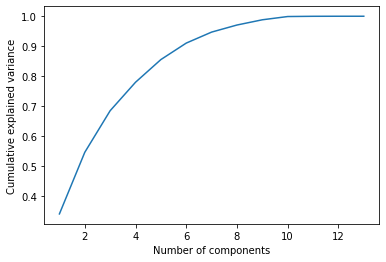

In [87]:
pca = PCA().fit(big_df)
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

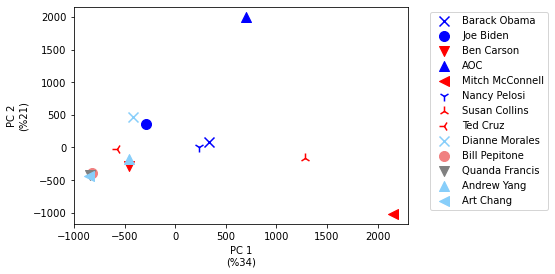

In [88]:
reduced_data = PCA(n_components=2).fit_transform(big_df)
results = pd.DataFrame(reduced_data,columns=['PC1','PC2'])
colors_national = ('b', 'b', 'r', 'b', 'r', 'b', 'r', 'r')
colors_local = ('lightskyblue', 'lightcoral', 'gray', 'lightskyblue', 'lightskyblue')
markers_national = ['x','o','v','^','<', '1', '2', '3']
markers_local = ['x','o','v','^','<']

labels_national = ('Barack Obama', 'Joe Biden', 'Ben Carson', 'AOC', 'Mitch McConnell', 'Nancy Pelosi', 'Susan Collins', 'Ted Cruz')
labels_local = ('Dianne Morales', 'Bill Pepitone', 'Quanda Francis', 'Andrew Yang', 'Art Chang')


fig, ax = plt.subplots()
for i,row in enumerate(results[:8].values):
    x=row[0]
    y=row[1]
    ax.scatter(x, y, s=100, marker=markers_national[i], color=colors_national[i], label=labels_national[i])
for i,row in enumerate(results[8:].values):
    x=row[0]
    y=row[1]
    ax.scatter(x, y, s=100, marker=markers_local[i], color=colors_local[i], label=labels_local[i])
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel(f'PC 1\n(%{pca.explained_variance_ratio_[0]*100:0.0f})')
ax.set_ylabel(f'PC 2\n(%{pca.explained_variance_ratio_[1]*100:0.0f})')
#fig.savefig('figures/PCA.pdf', bbox_inches='tight')
plt.show()

In [89]:
def create_similarity_matrix(similarity_tool,df_vectors):
    """
    Purpose: Take a dataframe with vectors of politicians and output a matrix showing similarity between them
    Arguments: similarity_tool: cosine similarity or euclidean distance, a dataframe with vectors
    Returns: a brand new dataframe with similarity scores
    """
    
    similarities = []
    
    iters = len(df_vectors.index)
    for i in range(iters):
        first_vec = df_vectors.iloc[i,:].values.reshape(1,-1)
        similarities.append([])
        for j in range(iters):
            second_vec = df_vectors.iloc[j,:].values.reshape(1,-1)
            similarities[i].append(similarity_tool(first_vec,second_vec)[0][0])
    
                
    df = pd.DataFrame(similarities, index=df_vectors.index, columns = df_vectors.index)      
    
    return df

cos_sim_df = create_similarity_matrix(cosine_similarity,big_df)
for column in cos_sim_df:
    print('The closest person to ' + str(column) + ' is ' + str(cos_sim_df[column].sort_values(ascending=False).index[1]))

The closest person to barackobama is SenatorCollins
The closest person to joebiden is SpeakerPelosi
The closest person to realbencarson is SpeakerPelosi
The closest person to AOC is barackobama
The closest person to McConnellPress is SenatorCollins
The closest person to SpeakerPelosi is realbencarson
The closest person to SenatorCollins is barackobama
The closest person to tedcruz is joebiden
The closest person to Dianne4NYC is AndrewYang
The closest person to PepitoneForNYC is tedcruz
The closest person to QuandaFrancis is joebiden
The closest person to AndrewYang is realbencarson
The closest person to achangnyc is QuandaFrancis


In [90]:
local_to_national = cos_sim_df.iloc[8:, :8]
national_to_local = cos_sim_df.iloc[:8, 8:]

In [91]:
for column in local_to_national:
    print('The closest person to ' + str(column) + ' is ' + str(local_to_national[column].sort_values(ascending=False).index[0]))

The closest person to barackobama is AndrewYang
The closest person to joebiden is AndrewYang
The closest person to realbencarson is AndrewYang
The closest person to AOC is Dianne4NYC
The closest person to McConnellPress is AndrewYang
The closest person to SpeakerPelosi is AndrewYang
The closest person to SenatorCollins is AndrewYang
The closest person to tedcruz is PepitoneForNYC


In [100]:
local_to_national['joebiden'].sort_values(ascending=False)

AndrewYang        0.578736
PepitoneForNYC    0.471056
Dianne4NYC        0.450434
QuandaFrancis     0.364349
achangnyc         0.317018
Name: joebiden, dtype: float64

In [41]:
for column in national_to_local:
    print('The closest person to ' + str(column) + ' is ' + str(national_to_local[column].sort_values(ascending=False).index[0]))

The closest person to Dianne4NYC is realbencarson
The closest person to PepitoneForNYC is tedcruz
The closest person to QuandaFrancis is joebiden
The closest person to AndrewYang is realbencarson
The closest person to achangnyc is joebiden


In [94]:
scott = national_to_local['AndrewYang'].sort_values(ascending=False)
scott

realbencarson     0.700489
SpeakerPelosi     0.649796
barackobama       0.613089
joebiden          0.578736
tedcruz           0.478813
SenatorCollins    0.456170
AOC               0.377982
McConnellPress    0.351712
Name: AndrewYang, dtype: float64

<AxesSubplot:>

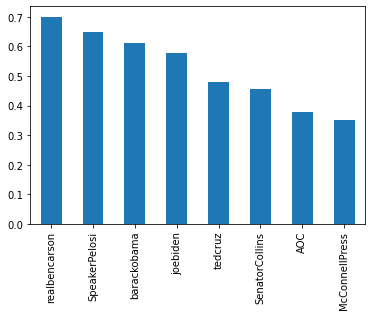

In [95]:
scott.plot.bar()